# imports

In [1]:
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import pearsonr
import numpy as np
import scipy
from datasets import Dataset, load_dataset
import json
import pandas as pd
import seaborn as sns

from collections import Counter

import pyperclip
import iso639
def copy_print(string):
    print(string)
    pyperclip.copy(string)

import matplotlib.pyplot as plt

import itertools


/home/paul/miniforge3/envs/matos/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# data

In [2]:
subset = load_dataset("PaulLerner/21-EuroParl")["test"].to_pandas()
subset["EU Party name"] = [party.split("/")[-1] for party in subset["EU Party"]]
eu_parties = sorted(subset["EU Party name"].unique())#{'EPP', 'NGL'}

languages = np.array(['bg',
 'cs',
 'da',
 'de',
 'el',
 'en',
 'es',
 'et',
 'fi',
 'fr',
 'hu',
 'it',
 'lt',
 'lv',
 'nl',
 'pl',
 'pt',
 'ro',
 'sk',
 'sl',
 'sv'])

# metric per sample

In [5]:

all_metrics = {k: [] for k in ["model","EU Party", "orig_src", 'sBLEU', 'COMET', 'src', 'tgt']}
for model in ["Qwen3-4B", "Qwen3-8B", "Llama-3.1-8B-Instruct"]:
    with open(f"/home/paul/code/bias/iznogoud/data/jz/text2text/21-multi-europarl/{model}/metrics.json","rt") as file:
        metrics = json.load(file)

    for metric in metrics:
        assert len(metric["BLEUs"]) == len(subset)
        for bleu, comet, country, n_party, eu_party, orig_src in zip(metric["BLEUs"], metric["wmt22-comet-das"], subset["EU Party name"], subset["src_lang"]):
            all_metrics["sBLEU"].append(bleu)
            all_metrics["model"].append(model)
            all_metrics["COMET"].append(comet*100)
            all_metrics["src"].append(metric["src"])
            all_metrics["tgt"].append(metric["tgt"])
            all_metrics["EU Party"].append(eu_party)
            all_metrics["orig_src"].append(orig_src)

all_metrics = pd.DataFrame(all_metrics)

all_metrics["translationese"] = "<->"
all_metrics.loc[all_metrics["orig_src"] == all_metrics["src"],"translationese"] = "src ->"
all_metrics.loc[all_metrics["orig_src"] == all_metrics["tgt"],"translationese"] = "src <-"

In [6]:
metric_name = "sBLEU"#"COMET"#"


In [46]:
all_metrics

,model,EU Party,National Party,country,orig_src,sBLEU,COMET,src,tgt,translationese
0,Qwen3-4B,EFA,E%C3%89_France,FR,fr,9.410490,88.610750,cs,bg,<->
1,Qwen3-4B,EPP,PP_Spain,ES,es,35.331246,85.508573,cs,bg,<->
2,Qwen3-4B,EPP,PP_Spain,ES,es,30.820866,63.346416,cs,bg,<->
3,Qwen3-4B,EPP,PP_Spain,ES,es,27.677945,88.599157,cs,bg,<->
4,Qwen3-4B,S&D,PD_Italy,IT,it,8.201319,70.532614,cs,bg,<->
...,...,...,...,...,...,...,...,...,...,...
29466355,Llama-3.1-8B-Instruct,ALDE,Darbo_partija_Lithuania,LT,lt,16.064554,92.841572,sl,sv,<->
29466356,Llama-3.1-8B-Instruct,ALDE,Darbo_partija_Lithuania,LT,lt,3.114248,90.915167,sl,sv,<->
29466357,Llama-3.1-8B-Instruct,ALDE,Darbo_partija_Lithuania,LT,lt,9.437676,95.232409,sl,sv,<->
29466358,Llama-3.1-8B-Instruct,EPP,Kres%25C5%25A5anskodemokratick%25C3%25A9_hnuti...,SK,sk,9.200468,90.711451,sl,sv,<->


# per language pair

## language pair plot

In [19]:
mean_metrics = []
for src, src_metrics in all_metrics.groupby("src", sort=False):
    for tgt, tgt_metrics in src_metrics.groupby("tgt", sort=False):
        for model, model_metrics in tgt_metrics.groupby("model",sort=False):
            mean_metrics.append(dict(src=src, tgt=tgt, model=model, sBLEU=model_metrics["sBLEU"].mean(), COMET=model_metrics["COMET"].mean()))

In [20]:
mean_metrics=pd.DataFrame(mean_metrics)

In [23]:
mean_metric = {}
for _, row in mean_metrics.iterrows():
    mean_metric.setdefault((row.src, row.tgt), [])
    mean_metric[(row.src, row.tgt)].append(row.sBLEU)
    mean_metric[(row.src, row.tgt)].append(row["COMET"])

In [24]:
mean_metric = pd.DataFrame(mean_metric).mean()

In [25]:
mean_metric=mean_metric.sort_values()

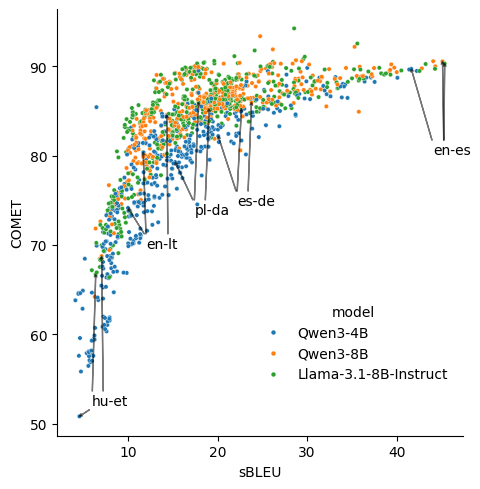

In [31]:

arrowprops=dict(facecolor='black', width=.1, headwidth=2, headlength=2, alpha=0.5)
fig=sns.relplot(mean_metrics, x="sBLEU", y="COMET", s=10, hue="model")
for src, tgt in mean_metric.iloc[np.linspace(0, len(mean_metric)-1, 5, dtype=int)].index:#[("hu", "et")]:
    lp_scores = mean_metrics[(mean_metrics["src"]==src) & (mean_metrics["tgt"]==tgt)]
    mean_lp_scores = lp_scores[["sBLEU", "COMET"]].mean()
    text = f'{src}-{tgt}'
    for _, row in lp_scores.iterrows():
        fig.ax.annotate(text, (row["sBLEU"], row["COMET"]), xytext=(mean_lp_scores["sBLEU"], mean_lp_scores["COMET"]-10),arrowprops=arrowprops)
        text="     "
sns.move_legend(fig, "lower right", bbox_to_anchor=(0.7, 0.2))
fig.savefig("sbleu_v_comet_s10.pdf")

In [74]:
pearson={}
for model, model_metrics in mean_metrics.groupby("model"):
    pearson[model]={}
    for imodel, imodel_metrics in mean_metrics.groupby("model"):
    
        pearson[model][imodel]=scipy.stats.pearsonr(model_metrics["sBLEU"],imodel_metrics["sBLEU"]).statistic

In [75]:
pd.DataFrame(pearson)

,Llama-3.1-8B-Instruct,Qwen3-4B,Qwen3-8B
Llama-3.1-8B-Instruct,1.000000,0.972441,0.981272
Qwen3-4B,0.972441,1.000000,0.978853
Qwen3-8B,0.981272,0.978853,1.000000


In [66]:
pearson={}
for model, model_metrics in mean_metrics.groupby("model"):
    pearson[model]={}
    for imodel, imodel_metrics in mean_metrics.groupby("model"):
    
        pearson[model][imodel]=scipy.stats.pearsonr(model_metrics["COMET"],imodel_metrics["COMET"]).statistic

In [67]:
pd.DataFrame(pearson)

,Llama-3.1-8B-Instruct,Qwen3-4B,Qwen3-8B
Llama-3.1-8B-Instruct,1.000000,0.885683,0.892251
Qwen3-4B,0.885683,1.000000,0.905166
Qwen3-8B,0.892251,0.905166,1.000000


## party borda

In [54]:
def borda_per_lang_pair(all_metrics, variable, p_thresh=0.01):
    ranks = Counter()
    p_values = {}
    bartlett_p = {}
    normal_p = {}
    chi_p={}
    all_mean_tgt_metrics_per_party = {}
    for src, src_metrics in all_metrics.groupby("src", sort=False):
        all_mean_tgt_metrics_per_party[src] = {}
        p_values[src] = {}
        normal_p[src] = {}
        bartlett_p[src] = {}
        chi_p[src] = {}
        for tgt, tgt_metrics in src_metrics.groupby("tgt", sort=False):
        
            tgt_metrics_per_party = []
            mean_tgt_metrics_per_party = {}
            tgt_normal_p, tgt_chi_p = [], []
            for party, party_metrics in tgt_metrics.groupby(variable, sort=False):
                tgt_metrics_per_party.append(party_metrics[metric_name])
                mean_tgt_metrics_per_party[party] = party_metrics[metric_name].mean()
            
            result=f_oneway(*tgt_metrics_per_party)
            p_values[src][tgt] = result.pvalue
            
            for i, k in enumerate(sorted(mean_tgt_metrics_per_party, key=mean_tgt_metrics_per_party.get)):
                ranks[k] += i
        all_mean_tgt_metrics_per_party[src][tgt]=mean_tgt_metrics_per_party
    
    
    ranks[f"$p<{p_thresh}$"] = (pd.DataFrame(p_values)<p_thresh).sum().sum()
    return ranks,all_mean_tgt_metrics_per_party

In [62]:
metric_name="COMET"#sBLEU"

In [63]:
ranks_per_model = {}
for model, model_metrics in all_metrics.groupby("model", sort=False):#all_metrics[all_metrics["translationese"]!="src <-"]
    ranks,all_mean_tgt_metrics_per_party = borda_per_lang_pair(model_metrics, "EU Party") #, equal_var=False)
    ranks_per_model[model] = ranks

In [64]:
ranks_per_model=pd.DataFrame(ranks_per_model).T

In [ ]:
copy_print(pd.concat((ranks_per_model['$p<0.01$'],ranks_per_model[eu_parties]/420),axis=1).to_markdown(floatfmt=".2f"))

# per target language


In [48]:
def borda_per_tgt(all_metrics, variable, p_thresh=0.01):
    ranks = Counter()
    p_values = {}
    all_mean_tgt_metrics_per_party = {}
    for tgt, tgt_metrics in all_metrics.groupby("tgt", sort=False):
        
        tgt_metrics_per_party = []
        mean_tgt_metrics_per_party = {}
        
        for party, party_metrics in tgt_metrics.groupby(variable, sort=False):
            tgt_metrics_per_party.append(party_metrics[metric_name])
            mean_tgt_metrics_per_party[party] = party_metrics[metric_name].mean()
        
        result=f_oneway(*tgt_metrics_per_party)
        p_values[tgt] = result.pvalue
        
        for i, k in enumerate(sorted(mean_tgt_metrics_per_party, key=mean_tgt_metrics_per_party.get)):
            if k=="en" and i != 19:
                print(tgt,k,i)
            ranks[k] += i
        if k!="en":
            print(tgt,k,i)
        all_mean_tgt_metrics_per_party[tgt]=mean_tgt_metrics_per_party
    
    
   # ranks=pd.DataFrame({model:ranks})
    ranks[f"$p<{p_thresh}$"] = (pd.DataFrame([p_values])<p_thresh).sum().sum()
    return ranks,all_mean_tgt_metrics_per_party

## party borda

In [30]:
ranks_per_model = {}
for model, model_metrics in all_metrics[all_metrics["translationese"]!="src <-"].groupby("model", sort=False):
    ranks,all_mean_tgt_metrics_per_party = borda_per_tgt(model_metrics, "EU Party")
    ranks_per_model[model] = ranks

In [31]:
ranks_per_model=pd.DataFrame(ranks_per_model).T

In [34]:
copy_print(pd.concat((ranks_per_model["$p<0.01$"],ranks_per_model[eu_parties]/21),axis=1).to_markdown(floatfmt=".2f"))

|                       |   $p<0.01$ |   ALDE |   ECR |   EFA |   EFD |   EPP |   NA |   NGL |   S&D |
|:----------------------|-----------:|-------:|------:|------:|------:|------:|-----:|------:|------:|
| Qwen3-4B              |      21.00 |   5.05 |  3.29 |  3.57 |  2.90 |  5.67 | 1.14 |  1.05 |  5.33 |
| Qwen3-8B              |      21.00 |   5.19 |  2.90 |  3.57 |  3.14 |  5.38 | 1.19 |  1.10 |  5.52 |
| Llama-3.1-8B-Instruct |      21.00 |   5.05 |  3.86 |  3.43 |  2.71 |  4.76 | 1.90 |  0.95 |  5.33 |


In [33]:
copy_print(pd.DataFrame(all_mean_tgt_metrics_per_party).to_markdown(floatfmt=".2f"))

|      |    bg |    cs |    da |    de |    el |    en |    es |   et |    fi |    fr |    hu |    it |   lt |   lv |    nl |    pl |    pt |    ro |    sk |    sl |    sv |
|:-----|------:|------:|------:|------:|------:|------:|------:|-----:|------:|------:|------:|------:|-----:|-----:|------:|------:|------:|------:|------:|------:|------:|
| EFA  | 18.10 | 17.58 | 19.57 | 20.79 | 17.13 | 34.46 | 28.96 | 8.30 | 10.83 | 25.14 | 13.12 | 20.50 | 9.05 | 9.12 | 19.88 | 15.65 | 23.27 | 21.68 | 13.42 | 13.56 | 19.93 |
| EPP  | 18.41 | 17.93 | 19.17 | 20.59 | 18.14 | 35.80 | 30.96 | 7.75 | 10.23 | 26.47 | 12.56 | 21.24 | 8.64 | 8.97 | 19.65 | 16.11 | 24.35 | 22.19 | 13.66 | 13.71 | 20.41 |
| S&D  | 18.74 | 18.04 | 19.22 | 20.70 | 18.24 | 36.29 | 30.39 | 7.86 | 10.25 | 26.06 | 12.53 | 21.07 | 8.70 | 8.96 | 20.04 | 16.26 | 23.94 | 22.22 | 13.90 | 13.80 | 20.56 |
| ALDE | 18.16 | 17.75 | 19.84 | 21.01 | 17.90 | 35.73 | 29.68 | 8.18 | 10.70 | 25.44 | 12.63 | 21.00 | 8.77 | 9.04 | 20.51 | 15.9

## language borda

In [49]:
ranks_per_model = {}
for model, model_metrics in all_metrics.groupby("model", sort=False):
    print(model)
    ranks,all_mean_tgt_metrics_per_party = borda_per_tgt(model_metrics, "src")
    ranks_per_model[model] = ranks

Qwen3-4B
cs en 18
cs sk 19
en es 19
sk en 18
sk cs 19
Qwen3-8B
cs en 18
cs sk 19
en es 19
sk en 18
sk cs 19
Llama-3.1-8B-Instruct
cs en 18
cs sk 19
en es 19
sk en 18
sk cs 19


In [116]:
ranks_per_model=pd.DataFrame(ranks_per_model).T

In [117]:
# 21 languages vote but only for 20 source so max score is 19*20 -> (19*20)/20 on average
copy_print(pd.concat((ranks_per_model["$p<0.01$"],ranks_per_model[languages]/20),axis=1).to_markdown(floatfmt=".2f"))

|                       |   $p<0.01$ |    bg |    cs |    da |    de |    el |    en |    es |   et |   fi |    fr |   hu |   it |   lt |   lv |   nl |   pl |    pt |    ro |    sk |   sl |   sv |
|:----------------------|-----------:|------:|------:|------:|------:|------:|------:|------:|-----:|-----:|------:|-----:|-----:|-----:|-----:|-----:|-----:|------:|------:|------:|-----:|-----:|
| Qwen3-4B              |      21.00 | 14.85 | 11.60 | 12.85 | 12.85 |  6.75 | 18.90 | 17.05 | 1.05 | 3.60 | 13.05 | 3.20 | 8.75 | 1.15 | 4.30 | 6.30 | 9.10 | 12.50 | 14.90 | 10.45 | 7.50 | 8.80 |
| Qwen3-8B              |      21.00 | 15.35 | 10.85 | 11.95 | 13.95 |  7.25 | 18.90 | 17.20 | 1.50 | 2.60 | 13.20 | 2.65 | 8.50 | 0.20 | 3.50 | 5.60 | 6.65 | 14.40 | 15.40 | 11.55 | 9.35 | 8.95 |
| Llama-3.1-8B-Instruct |      21.00 | 14.95 | 10.85 |  9.10 | 13.85 | 13.80 | 18.90 | 17.15 | 1.30 | 2.45 | 13.50 | 3.05 | 9.20 | 0.55 | 2.55 | 5.65 | 7.35 | 14.40 | 13.15 | 11.90 | 8.00 | 7.85 |


In [80]:
copy_print(pd.DataFrame(all_mean_tgt_metrics_per_party)[languages].T[languages].T.to_markdown(floatfmt=".1f"))

|    |    bg |    cs |    da |    de |    el |    en |    es |    et |    fi |    fr |    hu |    it |    lt |    lv |    nl |    pl |    pt |    ro |    sk |    sl |    sv |
|:---|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
| bg | nan   |  18.7 |  21.7 |  22.2 |  20.2 |  40.0 |  33.4 |   8.9 |  12.0 |  27.8 |  13.2 |  22.4 |  13.0 |  13.7 |  20.3 |  17.8 |  26.0 |  26.3 |  18.5 |  16.5 |  20.2 |
| cs |  22.0 | nan   |  20.3 |  21.7 |  18.8 |  36.3 |  30.3 |   8.6 |  11.3 |  25.7 |  12.4 |  21.0 |  11.7 |  12.4 |  19.2 |  17.4 |  23.3 |  23.5 |  26.2 |  15.6 |  18.5 |
| da |  21.4 |  17.1 | nan   |  22.9 |  18.4 |  39.7 |  31.5 |   8.8 |  11.9 |  26.9 |  12.7 |  21.4 |  11.4 |  12.5 |  20.1 |  15.8 |  24.0 |  23.4 |  16.7 |  14.6 |  25.4 |
| de |  21.9 |  18.3 |  22.4 | nan   |  19.0 |  39.2 |  32.6 |   9.2 |  12.1 |  27.4 |  12.9 |  22.2 |  11.9 |  12.3 |  22.5 

# language pair table

In [2]:
model = "Qwen3-8B"#"Qwen3-4B"#"Llama-3.1-8B-Instruct"#"Qwen3-8B"#"Llama-3.2-1B-Instruct"#"Llama-3.2-1B-Instruct"#"Llama-3.2-1B-Instruct"#
#/home/paul/code/bias/iznogoud/data/jz/text2text/21-multi-europarl/
with open(f"../../bias/iznogoud/data/exp/text2text/21-multi-europarl/{model}/metrics.json","rt") as file:
    metrics = json.load(file)

In [5]:
metric_name ="BLEU"# ""wmt22-comet-da"#

matrix = {}
for metric in metrics:
    matrix.setdefault(metric["src"], {})
    assert metric["tgt"] not in matrix[metric["src"]]
    matrix[metric["src"]][metric["tgt"]] = metric[metric_name]

In [231]:
#src/tgt
caption=r"""}
    \caption{%s scores of %s}
    \label{%s scores of %s}""" % (metric_name, model, metric_name, model)
copy_print(r"\resizebox{\textwidth}{!}{"+df.to_latex(float_format="%.1f")+caption)

\resizebox{\textwidth}{!}{\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrr}
\toprule
 & bg & cs & da & de & el & en & es & et & fi & fr & hu & it & lt & lv & nl & pl & pt & ro & sk & sl & sv \\
\midrule
bg & NaN & 90.6 & 87.4 & 85.8 & 83.9 & 89.0 & 87.7 & 76.1 & 84.5 & 86.8 & 86.2 & 88.7 & 78.0 & 75.4 & 86.8 & 90.4 & 87.2 & 90.0 & 84.5 & 84.9 & 88.7 \\
cs & 85.7 & NaN & 87.0 & 87.3 & 84.3 & 88.8 & 87.1 & 74.1 & 83.0 & 85.5 & 84.5 & 88.3 & 74.1 & 71.0 & 87.4 & 89.5 & 86.2 & 88.1 & 90.3 & 78.5 & 89.1 \\
da & 83.1 & 89.3 & NaN & 86.1 & 82.3 & 89.2 & 85.3 & 73.6 & 84.2 & 85.3 & 85.1 & 87.0 & 75.2 & 72.2 & 86.5 & 88.5 & 84.7 & 86.8 & 79.7 & 79.2 & 90.5 \\
de & 85.2 & 90.4 & 86.7 & NaN & 83.7 & 89.1 & 86.5 & 75.2 & 84.7 & 85.9 & 85.9 & 87.8 & 76.3 & 71.8 & 87.9 & 89.8 & 86.1 & 89.1 & 82.9 & 82.7 & 89.1 \\
el & 85.5 & 89.7 & 87.1 & 85.2 & NaN & 89.5 & 87.5 & 75.4 & 84.9 & 87.1 & 84.6 & 88.6 & 77.3 & 74.1 & 86.2 & 89.8 & 87.2 & 90.0 & 83.5 & 82.6 & 88.8 \\
en & 88.3 & 91.8 & 89.5 & 88.4 & 88.5 & NaN & 9